# Proyecto Final - Clasificación de Posibles Deudores

Hecho para la clase de Ciencia de Datos en CETYS Universidad LINI S7. Entregado el 5 de diciembre de 2022.

Hecho por: Alondra Guzman, Armando Lira, Angel Jurado, Natasha Lopez y Jackeline Lobato.

## Importación de librerías

In [3]:
# Importamos librerias para...
import pandas as pd # Manejar datos
import numpy as np # x2
import seaborn as sns # Graficar
from sklearn.svm import SVC # Clasificador que utiliza un Support Vector Machine
from sklearn.feature_selection import RFECV # Herramienta que facilita la selección de variables para los modelos
from sklearn.model_selection import GridSearchCV # Herramienta que facilita la optimización de parámetros para los modelos
from sklearn.metrics import accuracy_score # Nos permite saber que tan correcto es nuestra predicción
from sklearn.ensemble import RandomForestClassifier # Otro modelo para clasificación, usa un conjunto de decision trees
from sklearn.model_selection import train_test_split # Herramienta que permite la creación de conjuntos para entrenamiento y prueba
from sklearn.neighbors import KNeighborsClassifier # Modelo de clasificación que utiliza K Nearest Neighbors
from sklearn.neural_network import MLPClassifier # Modelo de clasificación que hace uso de redes neuronales
from copy import deepcopy as dc 

pd.set_option('display.max_columns', None)

## Carga de datos

In [4]:
# Cargamos conjunto de datos
credit = pd.read_csv("https://online.stat.psu.edu/onlinecourses/sites/stat508/files/german_credit.csv")
credit_names_short = ["creditability", "balance", "durcredit", "statusprevcredit", "purpose", "amount", "savings", "lenemployment", "instalment",
                      "sexmarital", "guarantors", "duraddress", "mostvalasset", "age", "concurrent", "apartment", "numcreditsbank", "occupation",
                      "numdependents", "phone", "foreignworker"] # Definimos nombres cortos para las columnas

credit_names_long = list(credit.columns)
credit_names = dict(zip(credit_names_short, credit_names_long)) # Usamos dict() y zip() para hacer un diccionario que al insertar el nombre corto nos da el nombre largo
credit.columns = credit_names_short # Asignamos los nombres cortos a los nombres de las columnas del conjunto

# "phone" y "foreignworker" ambas son variables binarias, para mantener al conjunto consistente decidimos que ambas representen a Si como 1 y No como 0
# En el conjunto original, en phone 1 es no y 2 es si, mientras que foreignworker es al revés
credit["phone"] = credit["phone"].map(lambda x: {1 : 0, 2 : 1}[x])
credit["foreignworker"] = credit["foreignworker"].map(lambda x: {1 : 1, 2 : 0}[x])

## Análisis exploratorio

In [26]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   creditability     1000 non-null   int64
 1   balance           1000 non-null   int64
 2   durcredit         1000 non-null   int64
 3   statusprevcredit  1000 non-null   int64
 4   purpose           1000 non-null   int64
 5   amount            1000 non-null   int64
 6   savings           1000 non-null   int64
 7   lenemployment     1000 non-null   int64
 8   instalment        1000 non-null   int64
 9   sexmarital        1000 non-null   int64
 10  guarantors        1000 non-null   int64
 11  duraddress        1000 non-null   int64
 12  mostvalasset      1000 non-null   int64
 13  age               1000 non-null   int64
 14  concurrent        1000 non-null   int64
 15  apartment         1000 non-null   int64
 16  numcreditsbank    1000 non-null   int64
 17  occupation        1000 non-null   

El conjunto se compone de 1000 renglones, cada uno representando a una persona que esta pidiendo un préstamo. En cada renglón tenemos 20 variables, la primera siendo la variable dependiente del proyecto: Creditability. Este es un valor binario que determina si una persona puede recibir el crédito y que probablemente lo va a liquidar.

El objetivo de este proyecto es generar un modelo que tome en cuenta las variables del conjunto para clasificar a las personas en dos grupos: 1, puede recibir un crédito y 0, no puede recibir un crédito. La intención es asumir correctamente ambos grupos pues al prestar a alguien que no puede liquidar la empresa pierde dinero y también al negar un préstamo a alquien que si puede pagarlo la empresa pierde un cliente potencial.

Se intentarán diferentes modelos, y se observará cuál de todos los modelos clasifica a los clientes potenciales con una mayor tasa de éxito.

Los únicos pasos de procesamiento que se aplicaron sonMuchos de las variables están en una especie de código o categorización, para entender el significado de cada uno puede dirigirse a esta página: https://online.stat.psu.edu/stat508/lesson/gcd


Las variables de mayor importancia son:
- Credit Amount
- Account Balance
- Age (years)
- Duration of Credit (month)
- Foreign Worker
- Payment Status of Previous Credit
- Telephone

En la prueba de modelos se mostrará como se decidió que estas son las variables más importantes

In [27]:
top_features_list = ['amount', 'balance', 'age', 'durcredit', 'foreignworker', 'statusprevcredit', 'phone']

top_features = dc(credit[top_features_list])
top_features.columns = list(map(lambda x: credit_names[x], top_features_list))
top_features

,Credit Amount,Account Balance,Age (years),Duration of Credit (month),Foreign Worker,Payment Status of Previous Credit,Telephone
0,1049,1,21,18,1,4,0
1,2799,1,36,9,1,4,0
2,841,2,23,12,1,2,0
3,2122,1,39,12,0,4,0
4,2171,1,38,12,0,4,0
...,...,...,...,...,...,...,...
995,1987,1,21,24,1,2,0
996,2303,1,45,24,1,2,0
997,12680,4,30,21,1,4,1
998,6468,2,52,12,1,2,1


In [28]:
sns.set(rc={'figure.figsize' : (12, 8)})

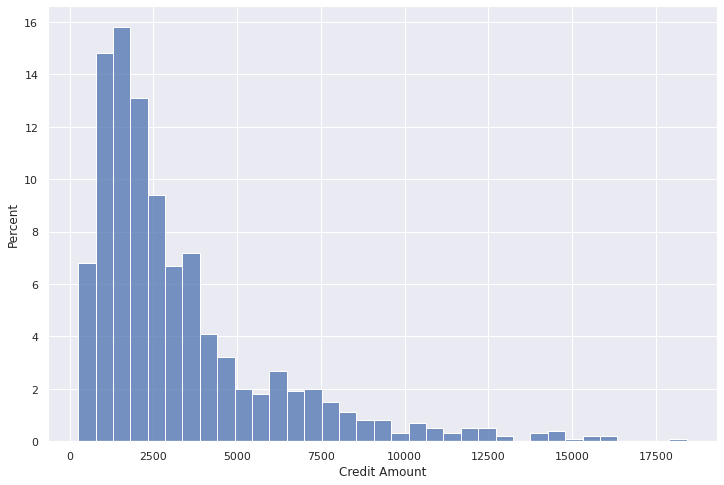

In [29]:
# Credit Amount
sns.histplot(data = top_features, x = "Credit Amount", stat = "percent")

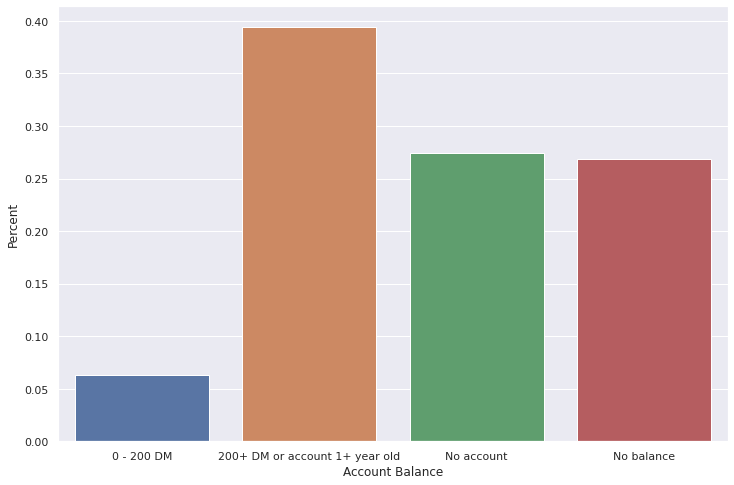

In [30]:
# Account Balance
balance_dict = {1 : "No account", 2 : "No balance", 3 : "0 - 200 DM", 4 : "200+ DM or account 1+ year old"}

balance_counts = pd.DataFrame()
balance_counts["Percent"] = list(map(lambda x: x / len(credit), credit["balance"].value_counts().values))
balance_counts["Account Balance"] = list(map(lambda x: balance_dict[x], credit["balance"].value_counts().index))
balance_counts = balance_counts.sort_values("Account Balance")

sns.barplot(data = balance_counts, x = "Account Balance", y = "Percent")

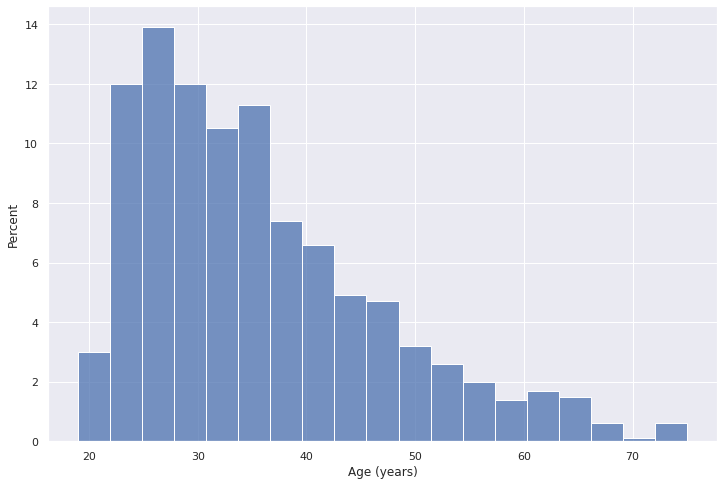

In [31]:
# Age (years)
sns.histplot(data = top_features, x = "Age (years)", stat = "percent")

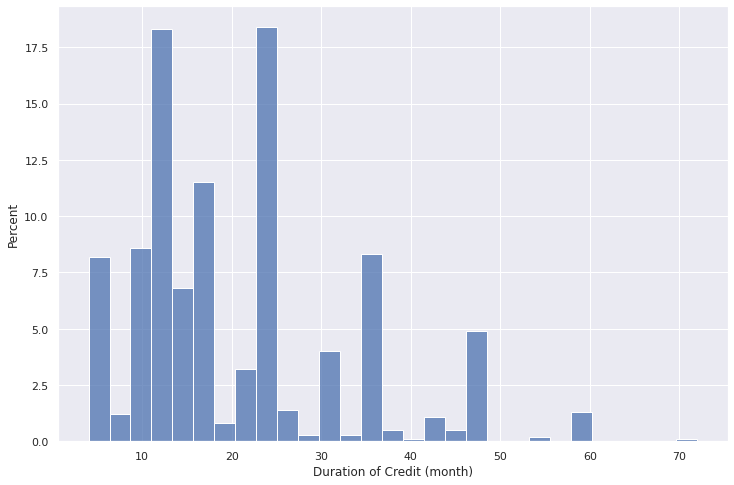

In [32]:
# Duration of Credit (month)
sns.histplot(data = top_features, x = "Duration of Credit (month)", stat = "percent")

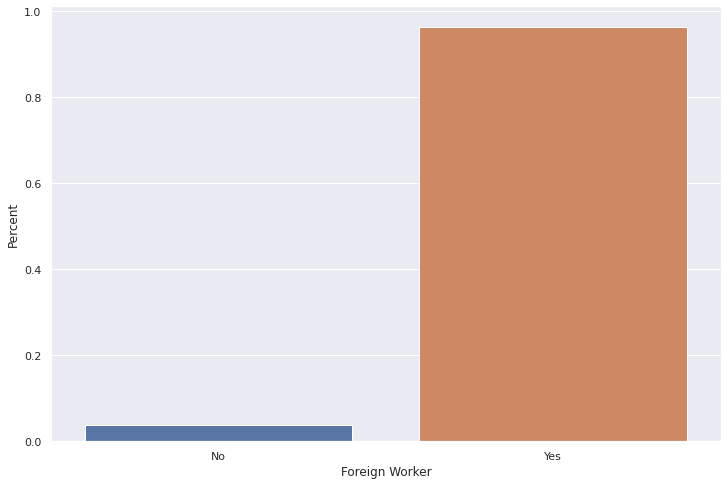

In [33]:
# Foreign Worker
foreign_dict = {1 : "Yes", 0 : "No"}

foreign_counts = pd.DataFrame()
foreign_counts["Percent"] = list(map(lambda x: x / len(credit), credit["foreignworker"].value_counts().values))
foreign_counts["Foreign Worker"] = list(map(lambda x: foreign_dict[x], credit["foreignworker"].value_counts().index))
foreign_counts = foreign_counts.sort_values("Foreign Worker")

sns.barplot(data = foreign_counts, x = "Foreign Worker", y = "Percent")

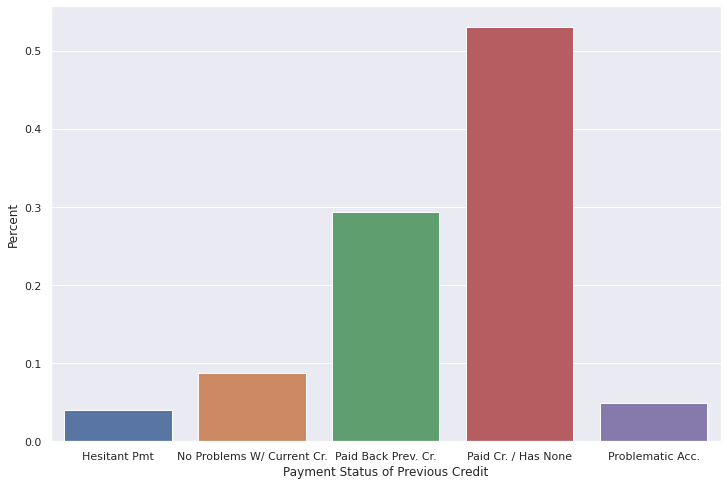

In [34]:
# Payment Status of Previous Credit
payment_dict = {0 : "Hesitant Pmt", 1 : "Problematic Acc.", 2 : "Paid Cr. / Has None", 3 : "No Problems W/ Current Cr.", 4 : "Paid Back Prev. Cr."}

payment_counts = pd.DataFrame()
payment_counts["Percent"] = list(map(lambda x: x / len(credit), credit["statusprevcredit"].value_counts().values))
payment_counts["Payment Status of Previous Credit"] = list(map(lambda x: payment_dict[x], credit["statusprevcredit"].value_counts().index))
payment_counts = payment_counts.sort_values("Payment Status of Previous Credit")

sns.barplot(data = payment_counts, x = "Payment Status of Previous Credit", y = "Percent")

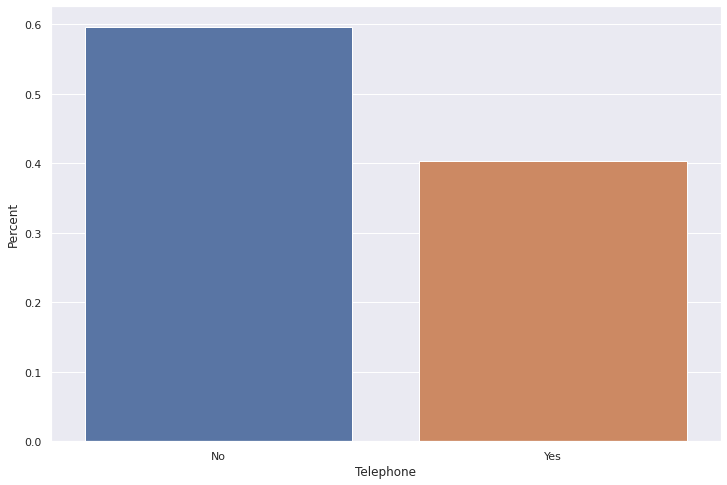

In [35]:
# Telephone
phone_dict = {0 : "No", 1 : "Yes"}

phone_counts = pd.DataFrame()
phone_counts["Percent"] = list(map(lambda x: x / len(credit), credit["phone"].value_counts().values))
phone_counts["Telephone"] = list(map(lambda x: phone_dict[x], credit["phone"].value_counts().index))
phone_counts = phone_counts.sort_values("Telephone")

sns.barplot(data = phone_counts, x = "Telephone", y = "Percent")

In [36]:
top_features[["Duration of Credit (month)", "Credit Amount", "Age (years)"]].corr() # Estas son las únicas variables del conjunto que no son categóricas

,Duration of Credit (month),Credit Amount,Age (years)
Duration of Credit (month),1.000000,0.624988,-0.037550
Credit Amount,0.624988,1.000000,0.032273
Age (years),-0.037550,0.032273,1.000000


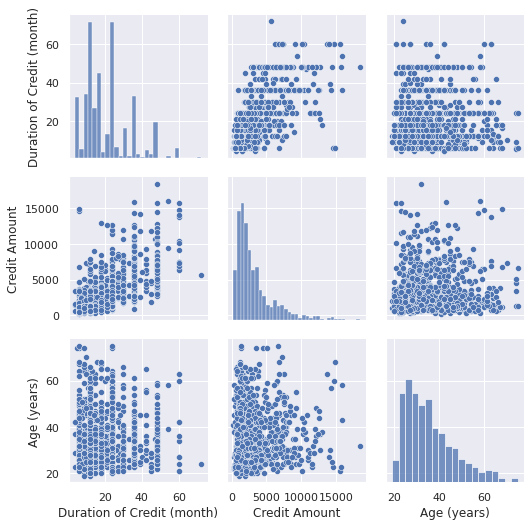

In [37]:
sns.pairplot(top_features[["Duration of Credit (month)", "Credit Amount", "Age (years)"]]) # Parece haber una correlación no muy duerte de la cantidad del crédito y la duración

## Prueba de modelos

### Creación de conjuntos de entrenamiento y prueba

In [5]:
X = credit[credit_names_short[1:]] # Se escogen todas las variables menos la primera, creditability
y = credit["creditability"] # Se escoge la variable dependiente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# El tamaño del conjunto de prueba será del 30%, el random_state 42 se usará para todo lo que lo use

In [6]:
selected_rf = ['balance', 'durcredit', 'statusprevcredit', 'purpose', 'amount',
       'savings', 'lenemployment', 'instalment', 'sexmarital', 'duraddress',
       'mostvalasset', 'age', 'apartment', 'numcreditsbank', 'occupation',
       'phone']
selected_svc = ['balance', 'durcredit', 'statusprevcredit', 'savings', 'lenemployment',
       'instalment', 'sexmarital', 'guarantors', 'duraddress', 'mostvalasset',
       'concurrent', 'apartment', 'numcreditsbank', 'occupation',
       'numdependents', 'phone', 'foreignworker']
# Conjuntos de variables seleccionados por RFECV y los modelos

### Random Forest

In [40]:
forest = RandomForestClassifier(random_state = 42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
accuracy_score(y_test, y_pred) # El accuracy score que nos da usando todas las variables y los parámetros default es de 77%

0.77

In [41]:
forest = RandomForestClassifier(random_state = 42)

selector_rf = RFECV(forest) # Usamos un seleccionador de variables con cross-validation
selector_rf.fit(X_train, y_train)
selected_rf = X.columns[selector_rf.support_] # El seleccionador nos regresa el conjunto de variables que nos dará el mejor resultado
print(selected_rf)

forest.fit(X_train[selected_rf], y_train)
y_pred = forest.predict(X_test[selected_rf])
accuracy_score(y_test, y_pred) # Al usar las variables seleccionadas, nuestro accuracy score baja, pero este valor es más confiable puesto a que fue por un cross-validation de 5 folds

Index(['balance', 'durcredit', 'statusprevcredit', 'purpose', 'amount',
       'savings', 'lenemployment', 'instalment', 'sexmarital', 'duraddress',
       'mostvalasset', 'age', 'apartment', 'numcreditsbank', 'occupation',
       'phone'],
      dtype='object')


0.7333333333333333

In [42]:
forest = RandomForestClassifier(random_state = 42)

# Optimización de parámetros, usando las variables seleccionadas
search = GridSearchCV(forest, {'n_estimators' : [100, 500, 1000], 'criterion' : ['gini', 'entropy'], 'max_depth' : [6, 8, 10]})
search.fit(X_train[selected_rf], y_train)

print(search.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 500}


In [43]:
forest = RandomForestClassifier(random_state = 42, criterion = "entropy", max_depth = 8, n_estimators = 500)
forest.fit(X_train[selected_rf], y_train)

y_pred = forest.predict(X_test[selected_rf])

accuracy_score(y_test, y_pred) # Después de usar los mejores parámetros y las variables ideales, nuestro accuracy score solo baja un 3.33% a comparación de la configuración default
# Sin embargo, este modelo es más fiable puesto a que fué por el proceso de cross validation tanto en su selección de variables como su optimización de parámetros

0.7666666666666667

In [44]:
importances = pd.DataFrame()
importances["Feature"] = selected_rf
importances["Importance"] = forest.feature_importances_
importances = importances.sort_values("Importance", ascending = False).reset_index(drop = True)
importances # Aquí las más importantes son amount, balance, durcredit y age

,Feature,Importance
0,amount,0.142350
1,balance,0.141900
2,durcredit,0.119063
3,age,0.107791
4,statusprevcredit,0.074823
5,purpose,0.064395
6,savings,0.058386
7,lenemployment,0.049452
8,instalment,0.043945
9,mostvalasset,0.038939


### Support Vector Machine

In [46]:
svc = SVC(random_state = 42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.7

In [47]:
svc = SVC(random_state = 42, kernel = 'linear') # Se usó el modelo lineal dado que provee un mayor nivel de precisión y se puede usar fácilmente con RFECV
selector_svc = RFECV(svc) 
selector_svc.fit(X_train, y_train)
selected_svc = X.columns[selector_svc.support_]
print(selected_svc)

Index(['balance', 'durcredit', 'statusprevcredit', 'savings', 'lenemployment',
       'instalment', 'sexmarital', 'guarantors', 'duraddress', 'mostvalasset',
       'concurrent', 'apartment', 'numcreditsbank', 'occupation',
       'numdependents', 'phone', 'foreignworker'],
      dtype='object')


In [48]:
svc.fit(X_train[selected_svc], y_train)
y_pred = svc.predict(X_test[selected_svc])
accuracy_score(y_test, y_pred)

0.7433333333333333

In [49]:
svc = SVC(random_state = 42, kernel = 'linear')

search = GridSearchCV(svc, {'C' : [0.1, 1, 10, 100]})
search.fit(X_train[selected_svc], y_train)

print(search.best_params_)

{'C': 10}


In [7]:
svc = SVC(random_state = 42, C = 10, kernel = 'linear')
svc.fit(X_train[selected_svc], y_train)

y_pred = svc.predict(X_test[selected_svc])
accuracy_score(y_test, y_pred)

0.7466666666666667

In [8]:
svc_coefs = pd.DataFrame(columns = ["feature", "coef"])
svc_coefs["feature"] = selected_svc
svc_coefs["coef"] = abs(svc.coef_[0])
svc_coefs = svc_coefs.sort_values("coef", ascending = False).reset_index(drop = True) # Las variables con mayor peso aquí son foreignworker, balance, statusprevcredit y phone
svc_coefs

,feature,coef
0,foreignworker,0.845553
1,balance,0.382950
2,statusprevcredit,0.382570
3,phone,0.317740
4,numcreditsbank,0.248688
5,guarantors,0.240979
6,instalment,0.201429
7,apartment,0.198605
8,savings,0.190062
9,sexmarital,0.186066


### K Nearest Neighbors

In [52]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.6666666666666666

In [53]:
knn = KNeighborsClassifier() # Por default KNN no puede usarse con RFECV sin introducir valores de importancia, así que se usarán las mismas variables del Random Forest
search = GridSearchCV(knn, {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
search = search.fit(X_train[selected_rf], y_train)
print(search.best_params_)

{'n_neighbors': 9}


In [54]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train[selected_rf], y_train)
y_pred = knn.predict(X_test[selected_rf])
accuracy_score(y_test, y_pred)

0.6666666666666666

In [55]:
knn = KNeighborsClassifier() # Lo mismo, pero ahora con los que sirvieron al SVC
search = GridSearchCV(knn, {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
search = search.fit(X_train[selected_svc], y_train)
print(search.best_params_)

{'n_neighbors': 9}


In [56]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train[selected_svc], y_train)
y_pred = knn.predict(X_test[selected_svc])
accuracy_score(y_test, y_pred) # Usar las variables del SVC dió un mejor resultado, pero no el mejor de todos los modelos

0.7066666666666667

### Clasificador por Redes Neuronales


In [57]:
# Primero se usó (20, 20, 20) para hidden layer sizes, dado que es la cantidad de variables del conjunto con tres capas
mlp = MLPClassifier(hidden_layer_sizes = (20, 20, 20), max_iter = 750, random_state = 42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6033333333333334


In [58]:
len(selected_rf)

16

In [59]:
# Aquí se estan usando las variables que fueron las mejores para el Random Forest
mlp = MLPClassifier(hidden_layer_sizes = (16, 16, 16), max_iter = 750, random_state = 42)
mlp.fit(X_train[selected_rf], y_train)
y_pred = mlp.predict(X_test[selected_rf])
print(accuracy_score(y_test, y_pred))

0.69


In [60]:
len(selected_svc)

17

In [61]:
# Por ultimo se intentó con las variables del SVM
mlp = MLPClassifier(hidden_layer_sizes = (17, 17, 17), max_iter = 1000, random_state = 42, activation = "tanh",)
mlp.fit(X_train[selected_svc], y_train) # Se aumento max_iter a 1000 puesto a que al usar 750 dio la advertencia que no se llegó al punto de convergencia
y_pred = mlp.predict(X_test[selected_svc])
print(accuracy_score(y_test, y_pred)) # tanh = 0.74, relu = 0.72

0.74


In [62]:
# Ajuste de parámteros
param_dict = {
    "hidden_layer_sizes" : [(17, 17, 17, 17), (17, 34, 51, 68)],
    "solver" : ["adam"],
    "alpha" : [0.0001, 0.0005, 0.00075, 0.001, 0.0025, 0.0075, 0.005],
    "learning_rate" : ["constant"],
    "activation" : ["relu"],
    "learning_rate_init" : [0.0001],
    "max_iter" : [10000]
}

In [63]:
mlp = MLPClassifier(random_state = 42)
search_mlp = GridSearchCV(mlp, param_dict)
search_mlp.fit(X_train[selected_svc], y_train)
print(search_mlp.best_params_)

{'activation': 'relu', 'alpha': 0.0075, 'hidden_layer_sizes': (17, 17, 17, 17), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'max_iter': 10000, 'solver': 'adam'}


In [64]:
mlp = MLPClassifier(max_iter = 10000, learning_rate_init = 0.0001, random_state = 42, activation = "relu",
                   hidden_layer_sizes = (17, 17, 17, 17), learning_rate = "constant", solver = "adam", alpha = 0.0005)
mlp.fit(X_train[selected_svc], y_train)
y_pred = mlp.predict(X_test[selected_svc])
print(accuracy_score(y_test, y_pred))

0.7366666666666667
